In [28]:
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load and cleaning data
 
Let us load the dataset, which we prepared in previous notebook

In [118]:
neighborhood_data = pd.read_csv('../data/Full_ba_neighborhood_data.csv', sep=',')
neighborhood_data.head()

,neighborhood,commune,perimeter_neib,area_neib,geometry,population,slum,amount_of_hospitals,station,day_noise,...,injuries_crime,property_crime,threats_crime,private_institution,state_institution,total_green_area,n_green_zones,n_green_zones_with_pati,mean_green_area,green_area_pct
0,AGRONOMIA,15,6556.17,2122169.34,POLYGON ((-58.475888981732986 -34.591723461272...,13912,0.0,0.0,0.0,22.211583,...,2.642857,29.055556,2.133333,6,16,6.092036e+03,11,0,553.821419,0.287066
1,ALMAGRO,5,8537.90,4050752.25,POLYGON ((-58.416002854915654 -34.597854231564...,131699,0.0,1.0,5.0,28.458668,...,24.444444,355.972222,24.250000,73,70,1.544574e+04,12,4,1287.144970,0.381305
2,BALVANERA,3,8375.82,4342280.27,POLYGON ((-58.392934155259674 -34.599636447011...,138926,0.0,1.0,12.0,27.401132,...,52.777778,597.944444,37.472222,74,100,4.625271e+04,9,6,5139.189604,1.065171
3,BARRACAS,4,12844.17,7954579.06,POLYGON ((-58.3706620577617 -34.62949214687238...,89452,2.0,6.0,0.0,32.513541,...,43.027778,286.055556,43.944444,30,86,3.968281e+05,101,17,3928.991535,4.988676
4,BELGRANO,13,20443.29,8025458.65,POLYGON ((-58.45056826999142 -34.5356114803969...,126267,0.0,1.0,2.0,26.384386,...,17.666667,291.055556,16.527778,69,37,1.588319e+06,66,13,24065.442280,19.791008


In [119]:
neighborhood_data.isnull().sum()

neighborhood               0
commune                    0
perimeter_neib             0
area_neib                  0
geometry                   0
population                 0
slum                       0
amount_of_hospitals        0
station                    0
day_noise                  0
night_noise                0
homicides_crime            0
injuries_crime             0
property_crime             0
threats_crime              0
private_institution        0
state_institution          0
total_green_area           0
n_green_zones              0
n_green_zones_with_pati    0
mean_green_area            0
green_area_pct             0
dtype: int64

In [120]:
df = neighborhood_data.copy()

In [121]:
df['schools_per_1000'] = (df['private_institution'] + df['state_institution']) / df['population'] * 1000
df['hospitals_per_1000'] = df['amount_of_hospitals'] / df['population'] * 1000
df['green_area_per_1000'] = df['total_green_area'] / df['population'] * 1000
df['crime_per_1000'] = (
    df['homicides_crime'] +
    df['injuries_crime'] +
    df['property_crime'] +
    df['threats_crime']
) / df['population'] * 1000

df['homicides_crime_per_1000'] = df['homicides_crime'] / df['population'] * 1000
df['property_crime_per_1000']  = df['property_crime'] / df['population'] * 1000
df['population_density'] = df['population'] / df['area_neib'] 
df['slum_density'] = df['slum'] / df['area_neib'] * 1000 

## Feature Normalization

In [130]:
features = [
    'population', 'slum_density', 'amount_of_hospitals', 'station', 'day_noise',
    'night_noise', 'homicides_crime', 'injuries_crime', 'property_crime',
    'threats_crime', 'private_institution', 'state_institution',
    'total_green_area', 'n_green_zones', 'n_green_zones_with_pati',
    'mean_green_area', 'green_area_pct', 'schools_per_1000', 'hospitals_per_1000',
    'green_area_per_1000', 'crime_per_1000', 'homicides_crime_per_1000', 
    'property_crime_per_1000', 'population_density'
]

Let us understand with which features we want to do a log transformation before scaling. For this puprose we will use skew function from scipy.stats.

In [131]:
def analyze_skewness(df, features, include_maybe = False, plot=False):
    results = []
    features_for_log = []
    for feature in features:
        original = df[feature].dropna()
        logged = np.log1p(original)

        skew_orig = skew(original)
        skew_logged = skew(logged)

        suggestion = "log1p" if skew_orig > 1 else ("maybe" if 0.5 < skew_orig <= 1 else "keep")
        if suggestion == "log1p" or suggestion == "maybe" and include_maybe == True:
            features_for_log.append(feature)

        results.append({
            "feature": feature,
            "skew_original": round(skew_orig, 3),
            "skew_log1p": round(skew_logged, 3),
            "suggestion": suggestion
        })

        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            sns.histplot(original, bins=30, ax=axs[0], kde=True)
            axs[0].set_title(f"{feature} (original)")

            sns.histplot(logged, bins=30, ax=axs[1], kde=True)
            axs[1].set_title(f"{feature} (log1p)")
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(results), features_for_log

In [132]:
data_features, features_for_log = analyze_skewness(df, features, include_maybe = True)
data_features

,feature,skew_original,skew_log1p,suggestion
0,population,1.576,-0.023,log1p
1,slum_density,2.352,2.352,log1p
2,amount_of_hospitals,2.391,1.249,log1p
3,station,1.712,0.818,log1p
4,day_noise,1.888,0.718,log1p
5,night_noise,-0.666,-1.578,keep
6,homicides_crime,-0.887,-1.474,keep
7,injuries_crime,1.360,0.126,log1p
8,property_crime,1.909,-0.074,log1p
9,threats_crime,1.479,-0.000,log1p


In [133]:
df_scaled = df.copy()
for feature in features_for_log:
    df_scaled[feature] = np.log1p(df[feature])

In [134]:
scaler = StandardScaler()

df_scaled[features] = scaler.fit_transform(df_scaled[features])

In [135]:
X = df_scaled[features].copy()

<Axes: xlabel='green_area_pct', ylabel='Count'>

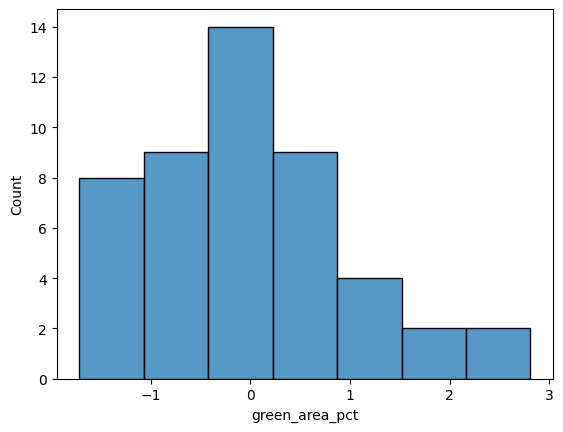

In [136]:
sns.histplot(data=X, x = 'green_area_pct')

## Feature selection

### 1. Correlation matrix

In [137]:
X.corr()

,population,slum_density,amount_of_hospitals,station,day_noise,night_noise,homicides_crime,injuries_crime,property_crime,threats_crime,...,n_green_zones_with_pati,mean_green_area,green_area_pct,schools_per_1000,hospitals_per_1000,green_area_per_1000,crime_per_1000,homicides_crime_per_1000,property_crime_per_1000,population_density
population,1.000000,0.092539,0.394717,0.503411,-0.076260,0.156233,0.400679,0.790590,0.903420,0.824733,...,0.619070,0.050625,-0.004813,-0.174491,-0.029405,-0.177158,-0.093955,-0.556977,-0.058033,0.612537
slum_density,0.092539,1.000000,-0.039505,-0.119855,-0.272016,-0.185958,0.452692,0.330572,0.154598,0.353570,...,0.366573,0.246225,0.446358,0.116205,-0.061107,0.434324,0.218164,0.175535,0.144234,-0.293565
amount_of_hospitals,0.394717,-0.039505,1.000000,0.219502,-0.169646,-0.133909,0.174454,0.367792,0.316856,0.385406,...,0.275649,0.158250,-0.001616,0.028072,0.796529,-0.022068,-0.100613,-0.185377,-0.122214,0.208781
station,0.503411,-0.119855,0.219502,1.000000,-0.143551,0.080755,0.320517,0.562993,0.643746,0.475999,...,0.105898,-0.045901,-0.068152,0.134303,-0.040435,-0.176235,0.360952,-0.167947,0.417165,0.630385
day_noise,-0.076260,-0.272016,-0.169646,-0.143551,1.000000,0.749186,-0.409472,-0.193011,-0.154283,-0.189151,...,-0.089717,-0.106256,-0.257300,-0.179774,-0.117453,-0.239597,-0.214617,-0.353394,-0.192511,0.145419
night_noise,0.156233,-0.185958,-0.133909,0.080755,0.749186,1.000000,-0.047963,0.083421,0.121655,0.031275,...,0.064642,-0.186063,-0.233144,-0.213973,-0.153717,-0.278510,-0.082318,-0.390953,-0.050490,0.311042
homicides_crime,0.400679,0.452692,0.174454,0.320517,-0.409472,-0.047963,1.000000,0.584932,0.514830,0.581688,...,0.609502,0.253397,0.343221,0.086806,-0.030828,0.327415,0.354737,0.347226,0.322203,0.099889
injuries_crime,0.790590,0.330572,0.367792,0.562993,-0.193011,0.083421,0.584932,1.000000,0.920205,0.973203,...,0.646755,0.158040,0.227452,0.234256,0.021119,0.101330,0.445395,-0.300201,0.426111,0.402850
property_crime,0.903420,0.154598,0.316856,0.643746,-0.154283,0.121655,0.514830,0.920205,1.000000,0.910935,...,0.622537,0.117123,0.142332,0.136649,-0.089901,-0.020016,0.337661,-0.391602,0.374926,0.548158
threats_crime,0.824733,0.353570,0.385406,0.475999,-0.189151,0.031275,0.581688,0.973203,0.910935,1.000000,...,0.693163,0.152536,0.204782,0.179965,0.038578,0.084590,0.357464,-0.308293,0.332738,0.375803


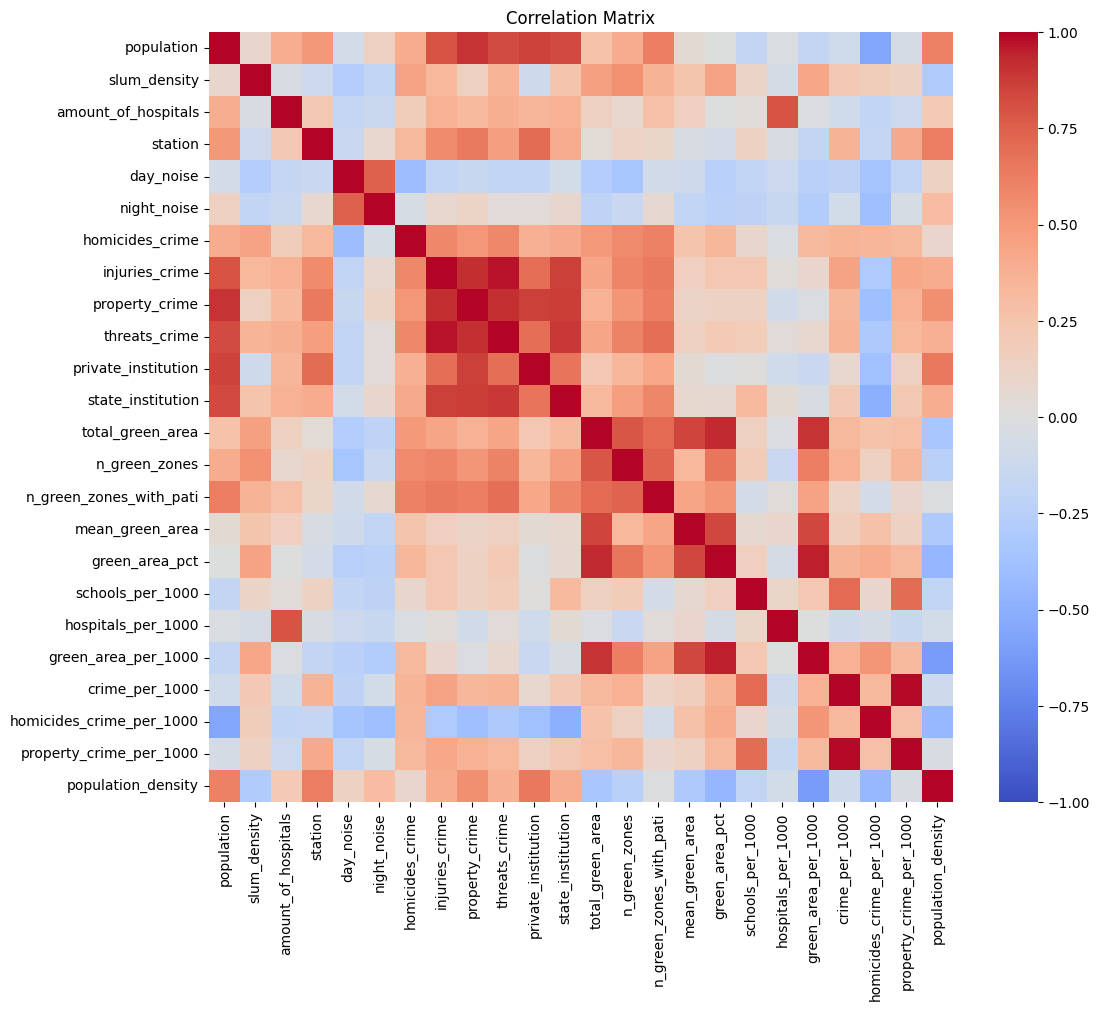

In [138]:

plt.figure(figsize=(12,10))
corr = X.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [139]:
features_to_drop_visually = ['population', 'total_green_area']
X = X.drop(columns=features_to_drop_visually)

In [140]:
def drop_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    # We take the upper triangular part to avoid duplicates
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # List of features to remove
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return df.drop(columns=to_drop), to_drop

In [141]:
X_clean, features_to_drop = drop_highly_correlated_features(X, threshold=0.9)

In [142]:
features_to_drop

['property_crime',
 'threats_crime',
 'green_area_per_1000',
 'property_crime_per_1000']

<Axes: >

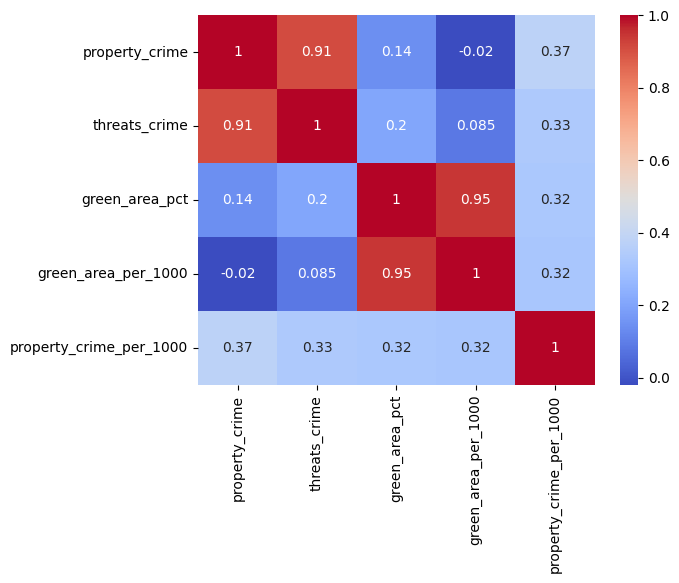

In [143]:
selected = ['property_crime', 'threats_crime', 'green_area_pct', 'green_area_per_1000', 'property_crime_per_1000']
sns.heatmap(df_scaled[selected].corr(), annot=True, cmap='coolwarm')

### 2. Principal Component Analysis

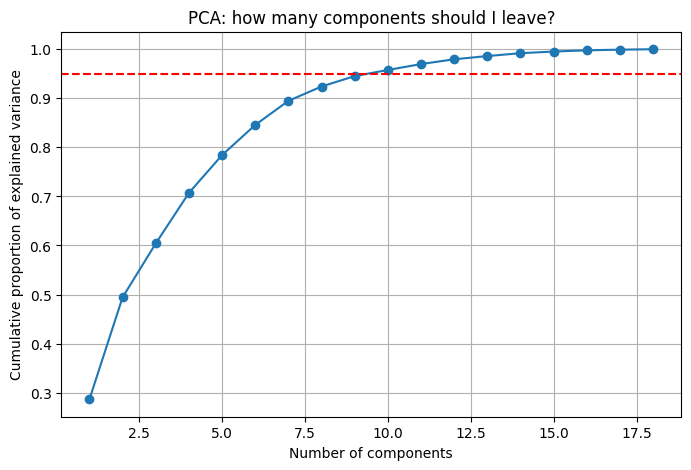

In [144]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(X_clean.columns))
X_pca = pca.fit_transform(X_clean)

explained_var = pca.explained_variance_ratio_

# Cumulative proportion of explained variance
cumulative_var = explained_var.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), cumulative_var, marker='o')
plt.axhline(y=0.95, color='red', linestyle='--')
plt.xlabel("Number of components")
plt.ylabel("Cumulative proportion of explained variance")
plt.title("PCA: how many components should I leave?")
plt.grid(True)
plt.show()

Feature importance

In [145]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(X_clean.columns))],
    index=X_clean.columns
)

loadings['PC1'].abs().sort_values(ascending=False)

injuries_crime              0.387748
n_green_zones               0.352458
n_green_zones_with_pati     0.338433
homicides_crime             0.330631
state_institution           0.329848
private_institution         0.276480
green_area_pct              0.242402
crime_per_1000              0.220732
slum_density                0.211155
station                     0.208958
mean_green_area             0.188417
day_noise                   0.181625
amount_of_hospitals         0.157740
schools_per_1000            0.137668
night_noise                 0.066769
population_density          0.058825
hospitals_per_1000          0.018166
homicides_crime_per_1000    0.005249
Name: PC1, dtype: float64

Heat map for feature contribution to principal components. Each cell is a contribution of a feature to a component.

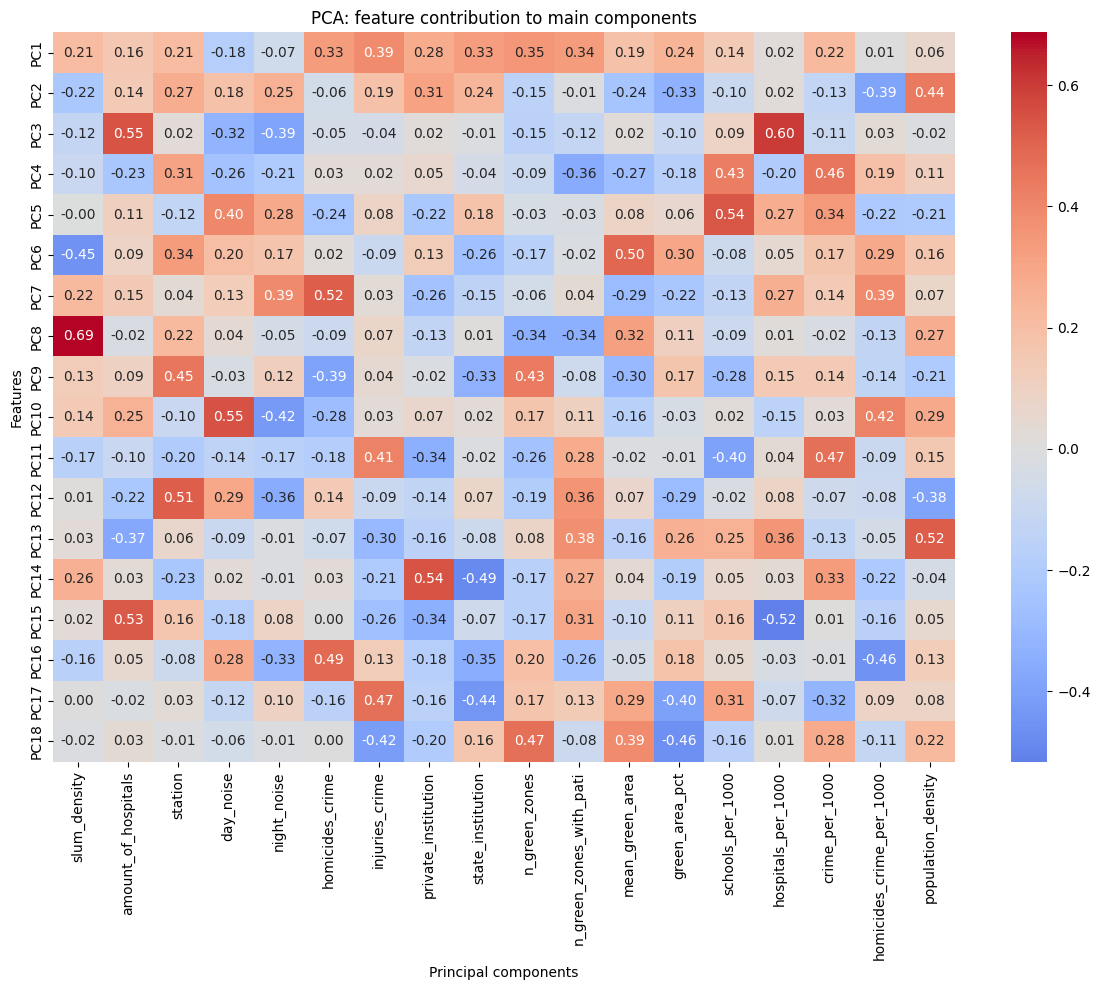

In [146]:
plt.figure(figsize=(12, 10))
sns.heatmap(loadings.T, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("PCA: feature contribution to main components")
plt.ylabel("Features")
plt.xlabel("Principal components")
plt.tight_layout()
plt.show()

In [147]:
pca_10 = PCA(n_components=10)
X_pca_10 = pca_10.fit_transform(X_clean)

In [148]:
df_pca = pd.DataFrame(
    X_pca_10,
    columns=[f'PC{i+1}' for i in range(X_pca_10.shape[1])]
)

df_pca['neighborhood'] = df['neighborhood'].values
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,neighborhood
0,-4.081867,-0.664407,1.289342,2.200154,0.025156,-2.254037,-1.824809,-0.021997,0.314820,-0.374363,AGRONOMIA
1,0.753140,3.612481,0.818300,1.493782,-1.510131,-0.097193,0.104068,0.579739,-0.891048,0.523675,ALMAGRO
2,2.441558,3.411162,0.708252,2.106574,-0.889644,0.905265,0.085845,1.061663,-1.225691,0.132116,BALVANERA
3,3.394041,0.305492,2.053399,-1.733288,1.413930,-1.135432,1.904449,-0.492344,-0.049130,0.231237,BARRACAS
4,1.902653,0.210091,0.379590,-1.333870,-1.336110,1.093926,-1.786131,-0.151977,0.242124,-0.151698,BELGRANO


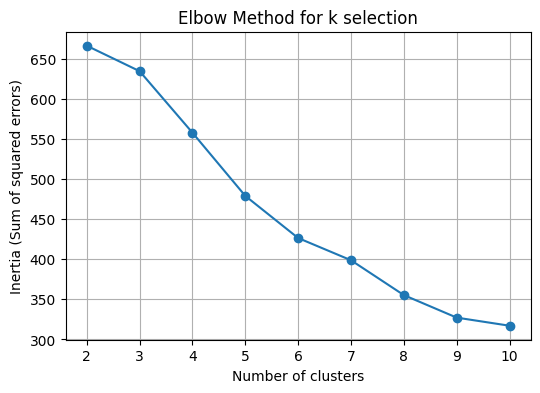

In [149]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_10) 
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (Sum of squared errors)")
plt.title("Elbow Method for k selection")
plt.grid(True)
plt.show()

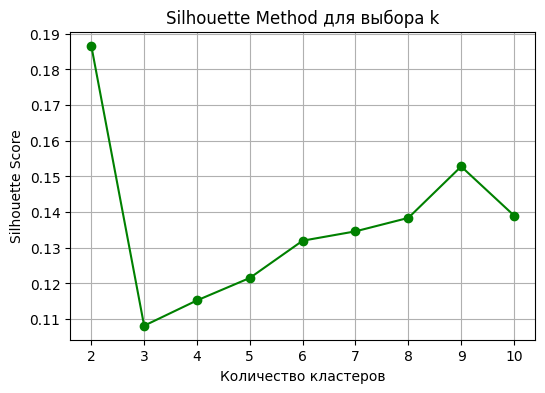

In [150]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca_10)
    score = silhouette_score(X_pca_10, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel("Количество кластеров")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method для выбора k")
plt.grid(True)
plt.show()

In [151]:
from sklearn.cluster import KMeans

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(X_pca_10)

In [152]:
df_clustered = df_scaled.copy()
df_clustered['cluster'] = df_pca['cluster'].values
X_clustered = X_clean.copy()
X_clustered['cluster'] = df_pca['cluster'].values

In [153]:
cluster_summary = X_clustered.groupby('cluster').mean().round(2)

cluster_summary

,slum_density,amount_of_hospitals,station,day_noise,night_noise,homicides_crime,injuries_crime,private_institution,state_institution,n_green_zones,n_green_zones_with_pati,mean_green_area,green_area_pct,schools_per_1000,hospitals_per_1000,crime_per_1000,homicides_crime_per_1000,population_density
cluster,,,,,,,,,,,,,,,,,,
0,-0.45,0.73,-0.77,0.10,-0.24,-0.80,-1.08,-0.86,-1.04,-1.27,-0.92,-0.18,-0.72,-0.41,1.52,-0.84,0.06,-0.22
1,0.60,-0.71,0.59,-0.02,0.47,0.53,0.80,0.10,0.39,0.71,0.11,-0.25,0.31,1.08,-0.56,1.50,0.14,-0.01
2,-0.45,-0.60,-0.17,0.36,0.13,-0.66,-0.59,-0.18,-0.27,-0.57,-0.60,-1.05,-0.99,-0.36,-0.48,-0.70,-0.33,0.33
3,0.01,-0.48,-0.62,0.40,0.48,-0.04,-0.40,-0.41,-0.24,0.02,0.20,0.80,0.61,-0.21,-0.41,-0.17,0.08,-0.67
4,2.30,-0.07,-0.77,-2.25,-2.83,0.99,-0.27,-0.94,-0.91,1.49,0.44,1.69,2.49,0.56,-0.11,1.21,2.93,-1.72
5,-0.19,1.47,0.95,-0.46,-0.37,0.61,1.11,1.21,0.98,0.43,0.78,0.33,0.12,-0.11,0.74,-0.00,-0.42,0.80


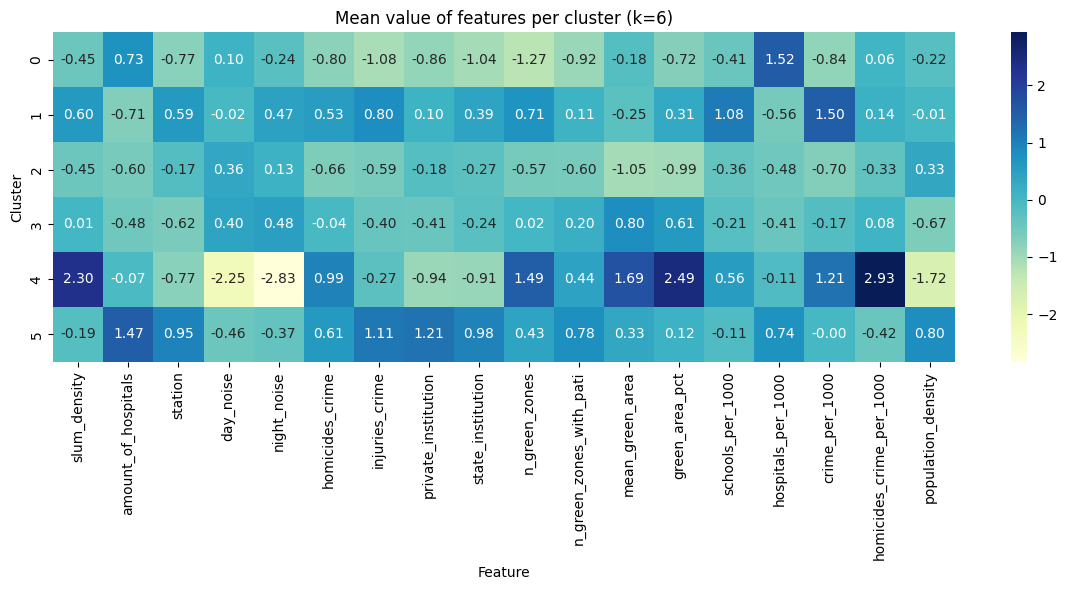

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Mean value of features per cluster (k=6)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [156]:
df_clustered.to_csv('../data/Full_data_clustered.csv', index=False)
X_clustered.to_csv('../data/Clean_feature_clustered.csv', index=False)